# Домашнее задание №3

Задание присылать на обе почты почты aleksartamonov@gmail.com dashkov.alexander.om@gmail.com в виде ссылки на colab

В теме письма указать **CV_HSE_2021 HW3 <Фамилия Имя>**

soft deadline: 21.03.2021T23:59:00+0300

hard deadline: 28.03.2021T23:59:00+0300


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import ipywidgets as widgets
import os
from sklearn.cluster import KMeans

## Legacy классификация

**Задане 1 (10 баллов)**

Реализуйте функцию, которая строит банк фильтров Габора.
Реализуйте интерактивный инструмент, в котором с помощью 2-х ползунков, один из которых отвечает за угол, другой за масштаб для фильтров из банка, можно выбрать конкретный фильтр и на экране отобразятся:
- Фильтр в пространственной области
- Фильтр в частотном пространстве
- Результат применения этого фильтра к какому-нибудь изображению.

In [ ]:
def gabour_bank(size, phi_bins, scale_bins, max_scale, min_scale):
    """
    Parameters:
    size (tuple|int): Size or radius of filters.
    phi_bins (int): Number of angle beens of bank
    scale_bins (int): Number of scales betwwen max_scale and min_scale
    max_scale (float): Max frequency covered by bank
    min_scale (float): Min frequency covered by bank
    Returns:
    list: a list of filters
    """
    angles = np.linspace(0, np.pi, num=phi_bins, endpoint=False) 
    frequences = np.linspace(min_scale, max_scale, num=scale_bins)

    gabour_bank = np.empty(shape=(phi_bins, scale_bins, size, size))
    for i, angle in enumerate(angles):
        for j, freq in enumerate(frequences):
            gabour = cv2.getGaborKernel(ksize=(size, size), sigma=4, theta=angle, lambd=freq, gamma=0.5)
            gabour_bank[i, j] = gabour

    return gabour_bank


In [ ]:
def show_gabour(filter, fourier_filter, img, size=3):
    fig, ax = plt.subplots(1, 3, figsize=(4.5 * size, size))
    ax[0].set_title('Filter')
    ax[0].set_axis_off()
    ax[0].imshow(filter, cmap='gray')
    
    ax[1].set_title('Filter Fourier transform')
    ax[1].set_axis_off()
    ax[1].imshow(fourier_filter, cmap='gray')
    
    ax[2].set_title('Image filter application')
    ax[2].set_axis_off()
    img = cv2.filter2D(img, cv2.CV_8UC3, filter)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax[2].imshow(img, cmap='gray')

def shift_fft(filter):
    filter = np.fft.fft2(filter)
    filter = np.abs(np.fft.fftshift(filter))
    filter = np.log(filter + 1e-10)

    return filter

In [ ]:
img = cv2.imread('zebry.jpg', 0)

size = 101
phi_bins = 50
scale_bins = 100
min_scale = 0.1
max_scale = 30


bank = gabour_bank(size, phi_bins, scale_bins, max_scale, min_scale)
angles = np.linspace(0, np.pi, num=phi_bins, endpoint=False) 
frequences = np.linspace(min_scale, max_scale, num=scale_bins)
indexes = {(str(angles[i]), str(frequences[j])): (i, j) for i in range(phi_bins) for j in range(scale_bins)}

@widgets.interact(lambd=widgets.SelectionSlider(options=frequences), angle=widgets.SelectionSlider(options=angles), )
def interact_gabour(lambd=frequences, angle=angles):
    i, j = indexes[(str(angle), str(lambd))]
    gabour = bank[i, j]
    fourier = shift_fft(gabour)
    show_gabour(gabour, fourier, img, size=4)

interactive(children=(SelectionSlider(description='lambd', options=(0.1, 0.40202020202020206, 0.70404040404040…

**Задание 2 (15 баллов)** 

Постройте мешок визульных слов на основе SIFT дескртипторов для датасета из третьего задания. Для этого для каждой картинки примените функцию, которая извлекает sift keypoints с дексрипторами, для каждой картинки ограничьтесь, например, сотней. Проведите кластеризацию на N(~30) классов, для каждого кластра отбразите в ряду 5 ближайших к нему участков изображений, в соответствии с масштабом keypoint-а. отобразите N таких строк.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install opencv-python-headless

In [4]:
!cp "/content/drive/MyDrive/Colab Notebooks/cv hw/hw3/sirius-traffic-lights-competition.zip" /content
!unzip -q sirius-traffic-lights-competition.zip

In [54]:
path = '/content/test/pic'
imgs = []

for img in os.listdir(path):
    imgs.append(cv2.imread(path + '/' + img))


In [62]:
def show(imgs, shape=None, size=3):
    imgs = imgs if isinstance(imgs, list) else [imgs]
    shape = (len(imgs), 1) if shape is None else shape
    rows, cols = shape
    fig, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))

    if rows == 1 or cols == 1:
        for ind, img in enumerate(imgs):
          plt.subplot(*shape, ind + 1)
        return

    item = 0
    for i in range(rows):
        for j in range(cols):  
            if item == len(imgs): 
                break
            ax[i][j].imshow(cv2.cvtColor(imgs[item], cv2.COLOR_BGR2RGB))
            ax[i][j].axis("off")
            item += 1
            

In [56]:
keypoints = []
descriptors = []
indices = []

sift = cv2.SIFT_create()

num_imgs = 3000
imgs = imgs[:num_imgs]

for i in range(num_imgs):
    img = cv2.cvtColor(imgs[i], cv2.COLOR_BGR2GRAY) 
    kp, desc = sift.detectAndCompute(img, None)
    
    for num in range(len(kp)):
        keypoints.append(kp[num])
        descriptors.append(desc[num])
        indices.append(i)

indices, keypoints, descriptors = map(np.array, [indices, keypoints, descriptors])

In [57]:
# clusterization

clust = KMeans(n_clusters=30).fit(descriptors)

In [63]:
def make_tile(img, x, y, rad):
  x, y = map(int, [x,y])
  img = img[y-rad : y+rad, x-rad:x+rad]
  return img


cluster_images = []
labels = np.unique(clust.labels_)
num_imgs_per_cluster = 100


# select 50 nearest points per cluster
for label in labels:
    mask = (clust.labels_ == label)
    ids = indices[mask]
    kp = keypoints[mask]
    desc = descriptors[mask] 
    clust_center = desc.mean(axis=0)

    dist = np.linalg.norm(desc - clust_center, axis=1)
    idx = np.argpartition(dist, num_imgs_per_cluster)[:num_imgs_per_cluster]

    # left 5 biggest of them
    kp = kp[idx]
    ids = ids[idx]
    size = [-keypoint.size for keypoint in kp]
    idx = np.argpartition(size, 5)[:5]

    # add data for plot
    for i in idx:
        keypoint = kp[i]
        x, y = map(np.round, keypoint.pt)
        rad = int(np.ceil(keypoint.size / 2) * 1.2)
        img = imgs[ids[i]]
        cluster_images.append(cv2.drawKeypoints(img, 
                                             [keypoint], 
                                             None, 
                                             flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))

        img = cv2.warpAffine(img, 
                             cv2.getRotationMatrix2D((x,y), keypoint.angle, 1),
                             img.shape[:2][::-1],
                             flags=cv2.INTER_LINEAR)
        
        tile = make_tile(img, x, y, rad)
        cluster_images.append(tile)


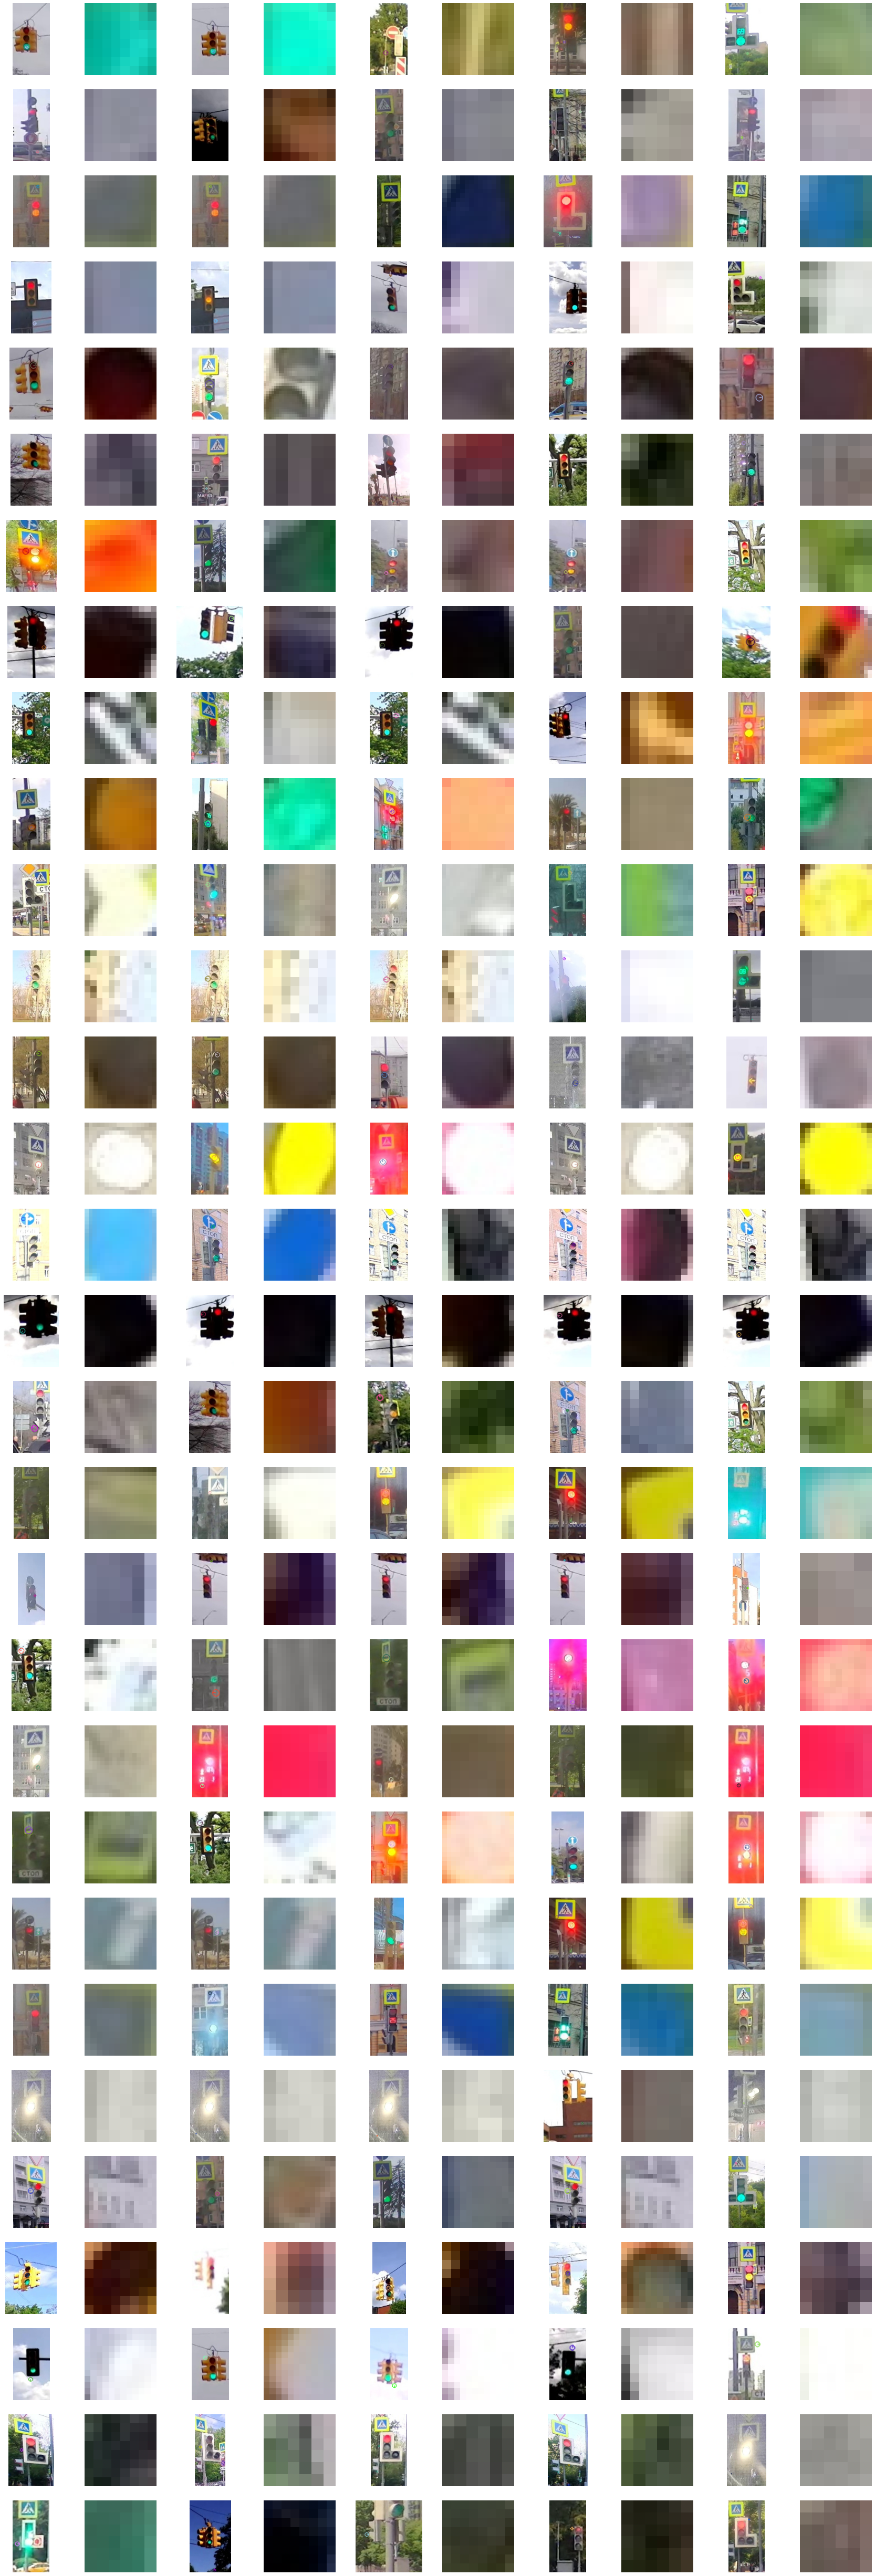

In [64]:
show(cluster_images, shape=(len(cluster_images) // 10, 10))

**Задание 3 (20 баллов)**

[КОНКУРС](https://youtu.be/8GGWedu77SA?t=3388)

В этом задании вам придется проявить изобретательность. Используйте банки фильтов, мешки визуальных слов и гистрограммы для достижения максимального скора. [Настоящая ссылка на конкурс](https://www.kaggle.com/t/65dc3b38e1194d488ab276752fd1e92d). В этом задании баллы будут распределяться согласно тому, как далеко вы продвинулись на лидерборде. **Важное условие**, весь ваш код положите в этот ноутбук, в нем не должно быть нейросетей =) Только legacy только *hard core*